In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
# from scipy.fft import irfft,rfft,rfftn,irfftn,fftn,ifftn,fft,ifft,fft2,rfft2
import itertools
from math import pi
# from orbithunter.glue import *
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft
from functools import lru_cache
from scipy.sparse.linalg import lsqr, lsmr, LinearOperator
from scipy.optimize import newton_krylov, root, minimize
%matplotlib inline
import time
import pandas as pd

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
def pairwise_glue(pair_of_orbits_array, class_constructor, gluing_axis=0):
    """

    Parameters
    ----------
    orbit
    other_orbit
    axis

    Returns
    -------

    Notes
    -----
    This function gives the user a lot more control over the result of gluing when considering only the
    combination of two orbits. This should be used when the optimal gluing is desired for a pair of orbits.
    """
    # Converts tori to best representatives for gluing by choosing from group orbit.
    # If we want a much simpler method of gluing, we can do "arraywise" which simply concatenates everything at
    # once. I would say this is the better option if all orbits in the tile dictionary are approximately equal
    # in size.
    # the "gluing axis" in this case is always the same, we are just iterating through the gluing shape one
    # axis at a time.
    glue_shape = tuple(2 if i == gluing_axis else 1 for i in range(2))
    corrected_pair_of_orbits = correct_aspect_ratios(pair_of_orbits_array, gluing_axis=0)
    # Bundle all of the parameters at once, instead of "stripwise"
    zipped_dimensions = tuple(zip(*(o.dimensions for o in pair_of_orbits_array.ravel())))
    glued_parameters = class_constructor.glue_parameters(zipped_dimensions, glue_shape=glue_shape)

    # arrange the orbit states into an array of the same shape as the symbol array.
    orbit_field_list = [o.convert(to='field').state for o in pair_of_orbits_array.ravel()]
    glued_orbit_state = np.array(orbit_field_list).reshape(*pair_of_orbits_array.shape, *tiling_shape)
    # iterate through and combine all of the axes.
    while len(glued_orbit_state.shape) > len(tiling_shape):
        glued_orbit_state = np.concatenate(glued_orbit_state, axis=gluing_axis)

    glued_orbit = class_constructor(state=glued_orbit_state, state_type='field',
                                    orbit_parameters=glued_parameters)


In [3]:
from orbithunter.discretization import correct_aspect_ratios

In [4]:
def group_orbit(orbit, half=0):
    gorbit =  np.array([orbit.to_fundamental_domain(half=0),
                     orbit.reflection().to_fundamental_domain(), 
                     orbit.cell_shift(axis=1).to_fundamental_domain(),
                     orbit.cell_shift(axis=1).reflection().to_fundamental_domain()])
    return gorbit

For pairwise gluing of orbits with discrete symmetry. Is it better to treat them as having no symmetry and rotating the
(corrected aspect) orbits? Or joining the different fundamental domains of the group orbit produced by discrete symmetry operations.

In [31]:
o = read_h5('OrbitKS_L31p245_T46p754.h5', state_type='field')
r = read_h5('OrbitKS_L38p516_T65p638.h5', state_type='field')


In [32]:
o1 = read_h5('ShiftReflectionOrbitKS_L22p000_T93p804.h5')
o2 = read_h5('ShiftReflectionOrbitKS_L34p465_T30p451.h5')

In [33]:
list(itertools.product(np.array([1,1,1]), np.array([0,1])))

[(1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1)]

In [34]:
gluing_axis=0
class_constructor = OrbitKS
zipped_dimensions = tuple(zip(*(o.dimensions for o in [o1, o2])))

glue_shape = tuple(2 if i == gluing_axis else 1 for i in range(2))
glued_parameters = class_constructor.glue_parameters(zipped_dimensions, glue_shape=glue_shape)

In [35]:
for fd1, fd2 in itertools.product(group_orbit(o1), group_orbit(o2)):
    new_orbit = o1.__class__(state=np.concatenate((fd1.state, fd2.state),axis=0), state_type='field', orbit_parameters=glued_parameters).from_fundamental_domain()
    print(new_orbit.residual())

345.06138530314996
345.4337930720178
331.68146301992005
331.53009593504925
345.4337930720179
345.06138530315
331.53009593504925
331.6814630199201
331.6814630199199
331.53009593504913
345.0613853031501
345.43379307201803
331.53009593504913
331.68146301992005
345.4337930720179
345.06138530314996


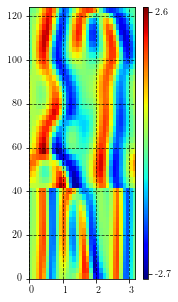

In [36]:
new_orbit.plot(padding=False)

In [37]:
srtest = ShiftReflectionOrbitKS(state=o.state, state_type='field', orbit_parameters=o.orbit_parameters).from_fundamental_domain()

In [38]:
oarray = np.array([rediscretize(x, new_shape=(32,32)) for x in [r, o]])

In [39]:
class_constructor = o.__class__

In [40]:
coarray = correct_aspect_ratios(np.array([o1,o2]), axis=0)
smallest_orbit = coarray[np.argmin((np.product(coarray[0].shape), np.product(coarray[1].shape)))]
larger_orbit = coarray[np.argmax((np.product(coarray[0].shape), np.product(coarray[1].shape)))]
resmat = np.zeros([smallest_orbit.N, smallest_orbit.M])
# The orbit only remains a converged solution if the rotations occur in
# increments of the discretization, i.e. multiples of L / M and T / N.
# The reason for this is because those are the only values that do not
# actually change the field via interpolation. In other words,
# The rotations must coincide with the collocation points.

In [41]:
import itertools

In [42]:
n, m = smallest_orbit.N, smallest_orbit.M

In [43]:
t0 = time.time()
roll_generator = (np.roll(np.roll(smallest_orbit.state, m, axis=1), n, axis=0) for n, m in itertools.product(range(n), range(m)))
residual_list = []
for rotated_state in roll_generator:
    glued_rotated_orbit = o.__class__(state=np.concatenate((rotated_state, larger_orbit.state),axis=gluing_axis), 
                                state_type='field', orbit_parameters=glued_parameters)
    residual_list.append(glued_rotated_orbit.residual())
res_array = np.array(residual_list).reshape(n, m)
t1 = time.time()
print(t1-t0)

0.4386117458343506


8.700911375714252e-21


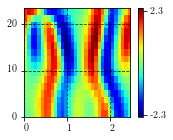

8.700911375714252e-21


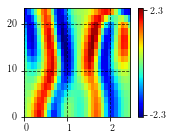

8.69826216264397e-21


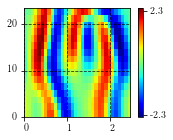

8.69826216264397e-21


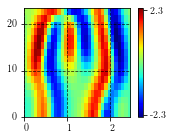

In [46]:
for go in group_orbit(o1):
    print(go.from_fundamental_domain().residual())
    go.plot(padding=False)

In [104]:
o1.reflection().residual()

8.703146000846272e-21

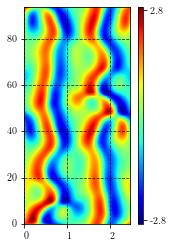

In [106]:
o1.plot(fundamental_domain=False)

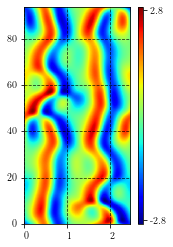

In [105]:
o1.reflection().plot(fundamental_domain=False)

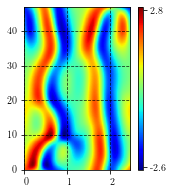

In [95]:
o1.plot(fundamental_domain=False)

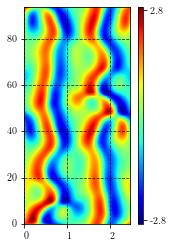

In [94]:
o1.plot(fundamental_domain=False)

In [46]:
class_constructor = o1.__class__

In [40]:
gluing_axis = 0

In [41]:
array_of_orbit_instances = np.array([o1, o2])

In [26]:
from orbithunter.discretization import correct_aspect_ratios

In [29]:
corrected_orbit_array =  correct_aspect_ratios(orb_array)

In [77]:
bottoms = np.concatenate([x.to_fundamental_domain().state for x in correct_aspect_ratios(orb_array)], axis=gluing_axis)

In [78]:
tops = np.concatenate([x.to_fundamental_domain(half='top').state for x in correct_aspect_ratios(orb_array)], axis=gluing_axis)

In [80]:
glue_shape

(2, 1)

In [82]:
bottoms_orbit = class_constructor(state=bottoms,
                 state_type='field',
                 orbit_parameters=glued_parameters
                ).from_fundamental_domain()

In [83]:
tops_orbit = class_constructor(state=tops,
                 state_type='field',
                 orbit_parameters=glued_parameters
                ).from_fundamental_domain()

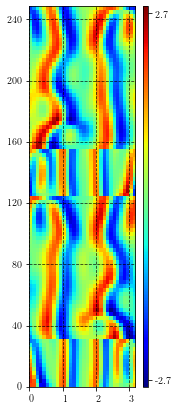

In [84]:
tops_orbit.plot(fundamental_domain=False, padding=False)

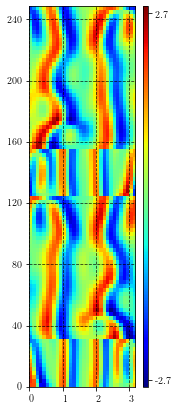

In [91]:
tops_orbit.plot(fundamental_domain=False, padding=False)

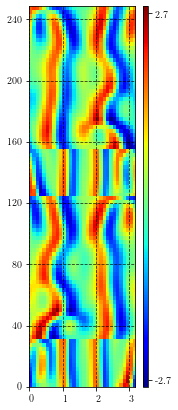

In [85]:
bottoms_orbit.plot(fundamental_domain=False, padding=False)

In [12]:
o = convert_class(o1, OrbitKS)

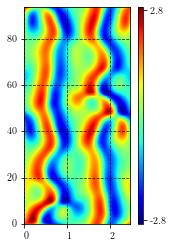

In [14]:
o.plot()

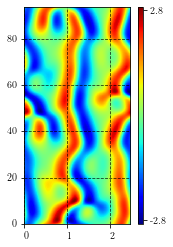

In [15]:
o.rotate(distance=5, axis=1).plot()


In [17]:
np.roll(np.ones([32, 32]), 0, axis=1)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [16]:
np.roll

In [ ]:
glue_shape = tuple(2 if i == gluing_axis else 1 for i in range(2))
corrected_pair_of_orbits = correct_aspect_ratios(pair_of_orbits_array, gluing_axis=0)